<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 NLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/NLinear.py

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [20]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/5.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.739264
1,0.737200
2,0.759168
3,0.741552
4,0.749392
...,...
38875,0.652168
38876,0.664736
38877,0.678984
38878,0.653888


In [21]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-NLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-NLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-NLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-NLinear']

In [22]:
class Model(nn.Module):
    def __init__(self,configs):
        super(Model,self).__init__()
        self.seq_len = int(configs['online-learning-NLinear']['seq_len'])
        self.pred_len = int(configs['online-learning-NLinear']['pred_len'])
        self.channels = int(configs['online-learning-NLinear']['enc_in'])
        self.individual = configs['online-learning-NLinear']['individual']
        self.device = torch.device('cuda:0')
        if self.individual == True:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len,self.pred_len)
    
    def forward(self,x):
        # x는 RNN Layer처럼 하나의 값이 하나의 텐서안에 들어가 있도록 즉 (batch_size,sequence_length,channe)
        seq_last = x[:,-1,:].view(-1,1,1) #.detach() 여기서 detach는 의미가 없어 보인다
        # https://bo-10000.tistory.com/181
        x = (x-seq_last)
        seq_last = seq_last.to(self.device)
        if self.individual == True:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])# 하나의 특성마다 각기 다른 Linear layer에 집어넣어줌
                # 이렇게 인덱싱하면 위에 처럼 linear layer에 넣기 좋게 나온다
            x = output
        else:
            x = self.Linear(x.permute(0,2,1).to(self.device)).permute(0,2,1)
            # Linear layer안에 있는 matrix와 다른 device에 들어있음
        x = x+seq_last
        return x #[Batch, Output length, Channel]

In [23]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)

In [24]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [25]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


In [26]:
x_seq

tensor([[[0.7393, 0.7372, 0.7592,  ..., 0.7869, 0.7698, 0.7890]],

        [[0.7372, 0.7592, 0.7416,  ..., 0.7698, 0.7890, 0.7862]],

        [[0.7592, 0.7416, 0.7494,  ..., 0.7890, 0.7862, 0.7815]],

        ...,

        [[0.6223, 0.6152, 0.5962,  ..., 0.7110, 0.6959, 0.6959]],

        [[0.6152, 0.5962, 0.6145,  ..., 0.6959, 0.6959, 0.6893]],

        [[0.5962, 0.6145, 0.6112,  ..., 0.6959, 0.6893, 0.6990]]],
       device='cuda:0')

In [27]:
target.size()

torch.Size([27360, 1, 1])

In [28]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq.permute(0,2,1))
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')       

Adjusting learning rate of group 0 to 9.5000e-06.
smape 19.27857581738448 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 14.081672913563706 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 12.183443504870374 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 11.69339623988459 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 10.391623712967188 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 11.178644947021416 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 10.096734514547109 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 9.641526958289726 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 9.012410117814328 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 8.370297210813876 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 7.653561195641843 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 8.109993931091232 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 8.461865883168072 %
Adjusti

In [29]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 16.040785938501358 %
SMAPE 18.397236868739128 %
SMAPE 9.753293380141258 %
SMAPE 3.4775184318423276 %
SMAPE 6.928294345736504 %
SMAPE 5.201401744037867 %
SMAPE 4.299517750740051 %
SMAPE 1.313984900712967 %
SMAPE 2.997741913422942 %
SMAPE 5.1201646365225315 %
SMAPE 0.07263954092610447 %
SMAPE 2.8591572418808937 %
SMAPE 6.4937097281217575 %
SMAPE 5.5704636834561825 %
SMAPE 2.7463166639208794 %
SMAPE 0.012945902059300352 %
SMAPE 2.8075325079262257 %
SMAPE 2.3778101317584515 %
SMAPE 7.796703025698662 %
SMAPE 4.074101462960243 %
SMAPE 2.7000801246613264 %
SMAPE 2.938676182180643 %
SMAPE 2.672080010175705 %
SMAPE 0.08321839240079498 %
SMAPE 1.1045457305735908 %
SMAPE 4.195224199444056 %
SMAPE 0.15613266324680808 %
SMAPE 1.9258352387696507 %
SMAPE 1.8014821680262683 %
SMAPE 2.6154488511383533 %
SMAPE 1.7196569759398699 %
SMAPE 3.727439122274518 %
SMAPE 0.9768286812686711 %
SMAPE 0.617204295052943 %
SMAPE 0.25244133964736193 %
SMAPE 3.597194731235504 %
SMAPE 0.02727554252248865 %
SMAPE 0.

SMAPE 0.3378371633502866 %
SMAPE 1.5357280920543417 %
SMAPE 9.28809204697609 %
SMAPE 0.2649827711479702 %
SMAPE 15.224669232964516 %
SMAPE 1.3673979403647536 %
SMAPE 1.192966255483043 %
SMAPE 4.736556928604841 %
SMAPE 10.18691372871399 %
SMAPE 2.2086900849826634 %
SMAPE 1.5812428458739303 %
SMAPE 0.03607667332607889 %
SMAPE 2.288296557031572 %
SMAPE 9.043867357075214 %
SMAPE 8.86516722291708 %
SMAPE 2.0806783214211464 %
SMAPE 0.10121252631006428 %
SMAPE 0.6998021989593326 %
SMAPE 6.388369768857956 %
SMAPE 2.40198122151196 %
SMAPE 6.915000405162573 %
SMAPE 0.2090486643355689 %
SMAPE 5.740802578628063 %
SMAPE 0.9748153379696305 %
SMAPE 2.614510183222592 %
SMAPE 1.3068110460881144 %
SMAPE 2.1804814990609884 %
SMAPE 2.545820507220924 %
SMAPE 0.7348472320172732 %
SMAPE 0.14839357199883807 %
SMAPE 4.055541241541505 %
SMAPE 1.088985220703762 %
SMAPE 4.380153637379408 %
SMAPE 5.918227069079876 %
SMAPE 0.8821284953232861 %
SMAPE 4.114460663869977 %
SMAPE 0.3236036983248596 %
SMAPE 0.22623541805

SMAPE 0.6205551661550999 %
SMAPE 1.1333059994503856 %
SMAPE 0.23603339021792635 %
SMAPE 0.44329591537825763 %
SMAPE 3.131578668951988 %
SMAPE 0.11317798977052006 %
SMAPE 0.9059797674417496 %
SMAPE 0.15375783823219535 %
SMAPE 1.731895251199603 %
SMAPE 1.7109200870618224 %
SMAPE 0.025546583319510322 %
SMAPE 0.7028061612509191 %
SMAPE 2.3538897838443518 %
SMAPE 0.7146007041446865 %
SMAPE 0.9057179014198481 %
SMAPE 0.057486099283437404 %
SMAPE 0.11301143232795141 %
SMAPE 2.7594177201390266 %
SMAPE 2.38769400306046 %
SMAPE 0.10888411209020887 %
SMAPE 0.9526447039097546 %
SMAPE 0.8831150219775737 %
SMAPE 0.9577484093606472 %
SMAPE 0.26740095438435674 %
SMAPE 3.1640079319477077 %
SMAPE 0.49455186910927296 %
SMAPE 0.0018444562765580486 %
SMAPE 0.4207896362058819 %
SMAPE 0.7770178983919322 %
SMAPE 1.5445502223446965 %
SMAPE 2.7969489507377148 %
SMAPE 0.7344208089634776 %
SMAPE 0.49495991785079246 %
SMAPE 1.9312665294855833 %
SMAPE 0.10774630890455228 %
SMAPE 2.2124662715941668 %
SMAPE 0.0920425

SMAPE 2.1568106040358543 %
SMAPE 0.004775244365191611 %
SMAPE 1.329433910548687 %
SMAPE 1.3315527252852917 %
SMAPE 0.500683878781274 %
SMAPE 0.3667876967228949 %
SMAPE 1.9317821487784386 %
SMAPE 0.618470564018935 %
SMAPE 2.676237877458334 %
SMAPE 0.32057793566491455 %
SMAPE 0.48232567496597767 %
SMAPE 0.11382375965695245 %
SMAPE 0.7675964189693332 %
SMAPE 0.34144637477584183 %
SMAPE 0.6083817277103662 %
SMAPE 1.3712026169523597 %
SMAPE 1.5499279191717505 %
SMAPE 0.09291864098827318 %
SMAPE 2.294917082414031 %
SMAPE 0.08974180233337847 %
SMAPE 0.004693802530425728 %
SMAPE 0.84585643094033 %
SMAPE 1.1254942556843162 %
SMAPE 0.8993083923123778 %
SMAPE 0.04822642850365355 %
SMAPE 1.3202363103628159 %
SMAPE 1.1494141640141606 %
SMAPE 0.574861214030534 %
SMAPE 1.8880626633763313 %
SMAPE 2.8203025460243225 %
SMAPE 0.012467317377513611 %
SMAPE 0.029721484664840148 %
SMAPE 0.24904224911006168 %
SMAPE 1.798375055193901 %
SMAPE 0.147742524693399 %
SMAPE 0.5718341646715999 %
SMAPE 0.11121802377726

SMAPE 0.7616747138090432 %
SMAPE 2.690437112003565 %
SMAPE 0.0471121307450062 %
SMAPE 0.14084940790053224 %
SMAPE 0.1765122923375202 %
SMAPE 1.1751754833385348 %
SMAPE 0.7790056429803371 %
SMAPE 0.4612140019889921 %
SMAPE 3.0941177122294903 %
SMAPE 0.11888195837696001 %
SMAPE 0.4700407912023366 %
SMAPE 1.098417678847909 %
SMAPE 0.4883145769126713 %
SMAPE 0.5825823326595128 %
SMAPE 2.427905661985278 %
SMAPE 2.0658182445913553 %
SMAPE 2.774225726723671 %
SMAPE 1.812060408294201 %
SMAPE 1.6318970918655398 %
SMAPE 0.03368587344027674 %
SMAPE 1.677276274189353 %
SMAPE 2.9179820604622364 %
SMAPE 1.356028032489121 %
SMAPE 1.3360138377174735 %
SMAPE 2.2834145296365023 %
SMAPE 0.07814871903815401 %
SMAPE 0.9760336321778594 %
SMAPE 0.5354154969099909 %
SMAPE 0.00935449022335888 %
SMAPE 1.073524272069335 %
SMAPE 0.531547500519082 %
SMAPE 1.2735285237431526 %
SMAPE 0.9422954958863557 %
SMAPE 0.20050000606715912 %
SMAPE 1.8037197906523943 %
SMAPE 0.025645694654897966 %
SMAPE 1.6806588908657432 %
SM

SMAPE 2.110993760637939 %
SMAPE 6.109309505671263 %
SMAPE 4.564211796969175 %
SMAPE 5.939104046672583 %
SMAPE 0.5595389465152039 %
SMAPE 1.8939836998470128 %
SMAPE 2.538249857723713 %
SMAPE 1.9932169681414962 %
SMAPE 2.731804342009127 %
SMAPE 0.32379571189949274 %
SMAPE 4.00408780016005 %
SMAPE 0.4679902190055145 %
SMAPE 0.030747678184525288 %
SMAPE 4.193595441058278 %
SMAPE 3.36450919136405 %
SMAPE 2.5311803817749023 %
SMAPE 0.3482252117440652 %
SMAPE 0.28902432262293587 %
SMAPE 0.2362892037667734 %
SMAPE 0.2674147674525784 %
SMAPE 0.04543577110706565 %
SMAPE 1.284155803907197 %
SMAPE 4.982704784721136 %
SMAPE 0.24059616317845212 %
SMAPE 0.32604103507947 %
SMAPE 0.8651833978910872 %
SMAPE 1.9575764955952764 %
SMAPE 0.35026209472623293 %
SMAPE 0.7847623094385199 %
SMAPE 2.7689502388238907 %
SMAPE 6.029676325619221 %
SMAPE 1.8093007788993416 %
SMAPE 3.8335021287202835 %
SMAPE 8.302904769778252 %
SMAPE 3.0400551091879606 %
SMAPE 2.5093922642990947 %
SMAPE 0.9064906809708191 %
SMAPE 2.496

SMAPE 1.0678698867559433 %
SMAPE 7.471763297915459 %
SMAPE 0.03335827040064032 %
SMAPE 1.5103252902626991 %
SMAPE 0.09387371676007206 %
SMAPE 0.4153936119128048 %
SMAPE 1.3376756245270371 %
SMAPE 0.4027375868695344 %
SMAPE 2.8602834437042475 %
SMAPE 0.3410396922242853 %
SMAPE 0.2466185563705494 %
SMAPE 2.2522083558142185 %
SMAPE 2.8620454035699368 %
SMAPE 3.317865539342165 %
SMAPE 0.04979437851670809 %
SMAPE 0.2520422393831723 %
SMAPE 0.12980786358679097 %
SMAPE 3.1320649571716785 %
SMAPE 0.24157324800216884 %
SMAPE 0.7892603547079489 %
SMAPE 1.2488408773206174 %
SMAPE 1.2068179724738002 %
SMAPE 0.13181012332915998 %
SMAPE 2.3417763225734234 %
SMAPE 1.4021692583337426 %
SMAPE 0.3267605914588785 %
SMAPE 0.7407566056353971 %
SMAPE 0.7773424759507179 %
SMAPE 1.355091986246407 %
SMAPE 0.4308567186444634 %
SMAPE 1.8681929577142 %
SMAPE 0.1688425509775584 %
SMAPE 0.3311273113831703 %
SMAPE 0.8985564841423185 %
SMAPE 1.0112530649639666 %
SMAPE 7.31466618180275 %
SMAPE 2.2812649812549353 %
SMA

SMAPE 0.3942302383948117 %
SMAPE 0.5851762434467673 %
SMAPE 0.9663317995145917 %
SMAPE 0.46939076157286763 %
SMAPE 0.1412779195306939 %
SMAPE 0.41232576686888933 %
SMAPE 0.0017918467412130214 %
SMAPE 0.2353410996729508 %
SMAPE 1.2744224332273006 %
SMAPE 0.8732435745187104 %
SMAPE 1.4663184378296137 %
SMAPE 0.020276972126822557 %
SMAPE 0.5993468933738768 %
SMAPE 0.35010161611717194 %
SMAPE 1.0241197934374213 %
SMAPE 0.6691239126957953 %
SMAPE 0.49028488574549556 %
SMAPE 1.483080274425447 %
SMAPE 0.3889646448660642 %
SMAPE 0.5101756739895791 %
SMAPE 1.0491855386644602 %
SMAPE 0.6858945693820715 %
SMAPE 0.5912182820029557 %
SMAPE 0.6010668822564185 %
SMAPE 1.0169299514964223 %
SMAPE 0.6376594165340066 %
SMAPE 0.41754982247948647 %
SMAPE 0.7469858163967729 %
SMAPE 0.2343835532665253 %
SMAPE 0.11529188392432844 %
SMAPE 0.8676265715621412 %
SMAPE 0.02635851457150551 %
SMAPE 0.08099307799182043 %
SMAPE 0.04232973930686512 %
SMAPE 0.0058579361644888195 %
SMAPE 1.1449293699115515 %
SMAPE 0.4923

SMAPE 0.043694519909522 %
SMAPE 0.6772846118547022 %
SMAPE 0.6140340883284807 %
SMAPE 0.9421532726846635 %
SMAPE 0.44377389596775174 %
SMAPE 0.5816313875839114 %
SMAPE 0.5619723664131016 %
SMAPE 0.23932502086972818 %
SMAPE 0.5423406909685582 %
SMAPE 1.3095753900706768 %
SMAPE 0.31178601644933224 %
SMAPE 0.20730056031607091 %
SMAPE 0.1397683949680868 %
SMAPE 0.5621199696324766 %
SMAPE 0.07575108973105671 %
SMAPE 2.1040534041821957 %
SMAPE 0.1372220188495703 %
SMAPE 0.00902087157163578 %
SMAPE 0.013676015602186451 %
SMAPE 0.8321708999574184 %
SMAPE 0.02093685908630505 %
SMAPE 0.2568625870044343 %
SMAPE 0.09555095860503116 %
SMAPE 0.3837001060601324 %
SMAPE 0.0869475678366598 %
SMAPE 0.34546853543724865 %
SMAPE 1.0523413866758347 %
SMAPE 0.7706083916127682 %
SMAPE 0.7951619001105428 %
SMAPE 0.45104302582331 %
SMAPE 1.645116108469665 %
SMAPE 0.8257268029265106 %
SMAPE 0.3342956284759566 %
SMAPE 0.9876453764736652 %
SMAPE 2.6526868976652622 %
SMAPE 1.0113869607448578 %
SMAPE 0.7091029644943

SMAPE 0.40955109463538975 %
SMAPE 0.641280606854707 %
SMAPE 0.16497485262539158 %
SMAPE 0.10694839576990489 %
SMAPE 1.8017011741176248 %
SMAPE 0.003718514055663036 %
SMAPE 2.54839844442904 %
SMAPE 0.5887994060758501 %
SMAPE 0.07572465136547635 %
SMAPE 0.08733711257877985 %
SMAPE 0.18219635638126874 %
SMAPE 0.1136015426557151 %
SMAPE 0.8386995578184724 %
SMAPE 2.132287008687854 %
SMAPE 0.42319692100863904 %
SMAPE 0.48460650630295277 %
SMAPE 0.4866219197865575 %
SMAPE 0.4545394064625725 %
SMAPE 0.003478219430810725 %
SMAPE 1.8040846763178706 %
SMAPE 0.4010194807779044 %
SMAPE 0.5327218535821885 %
SMAPE 1.3360256953164935 %
SMAPE 0.8168950099498035 %
SMAPE 0.008685814550325688 %
SMAPE 1.5487646665424109 %
SMAPE 0.028554995473996314 %
SMAPE 2.3753547966480255 %
SMAPE 2.378343241289258 %
SMAPE 0.19201262713795586 %
SMAPE 0.7477629375644028 %
SMAPE 0.015230193441539086 %
SMAPE 1.894950993359089 %
SMAPE 0.47549191163852816 %
SMAPE 1.712341597303748 %
SMAPE 0.3633075680700131 %
SMAPE 2.1777252

SMAPE 0.16303192614509499 %
SMAPE 0.43239715780578086 %
SMAPE 11.226560480892658 %
SMAPE 0.02666909311415111 %
SMAPE 0.2853200389270114 %
SMAPE 0.1863219208839837 %
SMAPE 17.47597335278988 %
SMAPE 0.0787946129712509 %
SMAPE 5.950598578900099 %
SMAPE 0.05482667844705701 %
SMAPE 4.812365351244807 %
SMAPE 0.10808930727077382 %
SMAPE 0.048242077095892455 %
SMAPE 0.06361341201613868 %
SMAPE 0.1511351482391774 %
SMAPE 7.583751454949379 %
SMAPE 1.5159919951733514 %
SMAPE 1.7749095546678293 %
SMAPE 7.760974571108818 %
SMAPE 1.5016012924061215 %
SMAPE 5.0448838621377945 %
SMAPE 0.4334073111813268 %
SMAPE 5.388968259096146 %
SMAPE 0.22976154154912362 %
SMAPE 3.403915490722284 %
SMAPE 1.068477179538604 %
SMAPE 16.96499653160572 %
SMAPE 4.464631346054375 %
SMAPE 0.06475894237928514 %
SMAPE 4.545060902833939 %
SMAPE 1.8475093253182422 %
SMAPE 0.36114240759459904 %
SMAPE 1.1283510901257614 %
SMAPE 7.546152297407388 %
SMAPE 0.10290133112630427 %
SMAPE 5.291319779120386 %
SMAPE 16.534970551729202 %
SM

SMAPE 2.131338695064187 %
SMAPE 1.215339520946145 %
SMAPE 0.14284990535998077 %
SMAPE 0.4947509025223553 %
SMAPE 1.452800846658647 %
SMAPE 1.204087066464126 %
SMAPE 0.6335933054797351 %
SMAPE 2.893313530832529 %
SMAPE 0.35020768572576344 %
SMAPE 0.12042526699542577 %
SMAPE 1.9047705940902233 %
SMAPE 0.2375752265797928 %
SMAPE 2.636398443952203 %
SMAPE 1.3806453803554177 %
SMAPE 1.3961793528869748 %
SMAPE 0.2775227486854419 %
SMAPE 0.13359183795091667 %
SMAPE 4.577387101948261 %
SMAPE 2.2365313190966845 %
SMAPE 0.7930476507171988 %
SMAPE 2.659873189404607 %
SMAPE 0.35020735615398735 %
SMAPE 0.5904250841122121 %
SMAPE 0.9527668114751577 %
SMAPE 0.28341188555350527 %
SMAPE 0.9452545242384076 %
SMAPE 0.06540127485743596 %
SMAPE 3.613695230334997 %
SMAPE 0.15503910425150025 %
SMAPE 1.4679828565567732 %
SMAPE 0.5531296441331506 %
SMAPE 3.5218113027513027 %
SMAPE 1.3725273422896862 %
SMAPE 3.2782974205911164 %
SMAPE 0.7609938932582736 %
SMAPE 1.7686464376747608 %
SMAPE 1.869886549189687 %
SMA

SMAPE 0.3330139844911173 %
SMAPE 1.1155614061281085 %
SMAPE 0.6209794306196272 %
SMAPE 1.145384231582284 %
SMAPE 0.3133968983311206 %
SMAPE 0.31047973199747503 %
SMAPE 0.5639091730117798 %
SMAPE 1.071662824600935 %
SMAPE 0.09951998986912258 %
SMAPE 0.5390429275576025 %
SMAPE 0.6595734218135476 %
SMAPE 0.004621866807354991 %
SMAPE 0.26600438088644296 %
SMAPE 0.08778853130760922 %
SMAPE 0.4860333318356424 %
SMAPE 0.1980110467702616 %
SMAPE 0.6352649237960577 %
SMAPE 0.9706115843728184 %
SMAPE 0.035244948482926475 %
SMAPE 0.6774104903452098 %
SMAPE 0.17581873111703317 %
SMAPE 0.08945761235418104 %
SMAPE 1.9312328957021236 %
SMAPE 0.03450744209868617 %
SMAPE 1.0593765173107386 %
SMAPE 2.014970123767853 %
SMAPE 0.03885698818965011 %
SMAPE 1.3333044527098536 %
SMAPE 1.1519925715401769 %
SMAPE 0.30752948962617666 %
SMAPE 2.2038478814065456 %
SMAPE 0.7605554740875959 %
SMAPE 1.0589894810691476 %
SMAPE 0.37246812391094863 %
SMAPE 0.004283957979282604 %
SMAPE 0.33032925229053944 %
SMAPE 1.861773

SMAPE 0.49041470466181636 %
SMAPE 0.6270677051506937 %
SMAPE 0.1232892121410316 %
SMAPE 1.2711981674656272 %
SMAPE 0.8779407194815576 %
SMAPE 0.002035706409756699 %
SMAPE 1.786555388942361 %
SMAPE 1.2537882355973125 %
SMAPE 0.46381205925717955 %
SMAPE 1.2503030840307474 %
SMAPE 1.0152263129130006 %
SMAPE 0.03027605336023953 %
SMAPE 0.5262336742598563 %
SMAPE 0.6723984275013208 %
SMAPE 0.15031320416164817 %
SMAPE 0.3243912694742903 %
SMAPE 0.04920533813015027 %
SMAPE 0.22848842936218716 %
SMAPE 0.06322954582390139 %
SMAPE 1.72368379868567 %
SMAPE 0.2363555932533927 %
SMAPE 0.007779969982181 %
SMAPE 1.1938523184508085 %
SMAPE 0.2104872023774078 %
SMAPE 1.2949137333780527 %
SMAPE 1.371257376857102 %
SMAPE 0.19437271249034893 %
SMAPE 0.9166214019060135 %
SMAPE 0.6453541861847043 %
SMAPE 0.032010921981850515 %
SMAPE 0.29653576645068824 %
SMAPE 0.07803182250859209 %
SMAPE 0.385545386117883 %
SMAPE 0.7409418788738549 %
SMAPE 0.38056700909510255 %
SMAPE 0.19589942489983514 %
SMAPE 0.2088980970

SMAPE 0.4163208777717955 %
SMAPE 3.365317035466433 %
SMAPE 2.963703028857708 %
SMAPE 4.002267759293318 %
SMAPE 0.007824404764804171 %
SMAPE 1.4873574487864971 %
SMAPE 3.7342379651963715 %
SMAPE 0.17006810102907366 %
SMAPE 2.523820884525776 %
SMAPE 2.4293005373328924 %
SMAPE 0.7914008612278849 %
SMAPE 0.8779371869750321 %
SMAPE 0.5402239899849519 %
SMAPE 1.6488553965464237 %
SMAPE 2.027251774445176 %
SMAPE 0.08906733805770273 %
SMAPE 2.547245007008314 %
SMAPE 1.064359050244093 %
SMAPE 0.9966139625757933 %
SMAPE 0.8278169473633169 %
SMAPE 0.338756273729814 %
SMAPE 1.2155652130022645 %
SMAPE 1.721912870183587 %
SMAPE 4.686862871050835 %
SMAPE 0.5795504881534725 %
SMAPE 2.012521654367447 %
SMAPE 1.1809158883988857 %
SMAPE 2.393095090985298 %
SMAPE 1.2929162867367268 %
SMAPE 0.16333056868279527 %
SMAPE 3.2103160545229907 %
SMAPE 1.3344210181385279 %
SMAPE 1.9554871153086424 %
SMAPE 2.6764173172414303 %
SMAPE 0.7067557752598077 %
SMAPE 1.967204219661653 %
SMAPE 1.863772727549076 %
SMAPE 0.02

SMAPE 0.48247742380908676 %
SMAPE 4.095220155082643 %
SMAPE 0.032703008535463596 %
SMAPE 3.7586553525179625 %
SMAPE 2.109126719071355 %
SMAPE 3.2286037707235664 %
SMAPE 19.9334626942873 %
SMAPE 11.288640759885311 %
SMAPE 0.4580864936281159 %
SMAPE 0.05037888135416324 %
SMAPE 9.66035470366478 %
SMAPE 1.008722676021307 %
SMAPE 3.495578062720597 %
SMAPE 8.52721169963479 %
SMAPE 0.4919040182162462 %
SMAPE 3.9303338984027505 %
SMAPE 5.020719239488244 %
SMAPE 15.191913902759552 %
SMAPE 9.3908282071352 %
SMAPE 6.71831525489688 %
SMAPE 0.35441302309845923 %
SMAPE 7.485520448535681 %
SMAPE 1.2654491118719307 %
SMAPE 12.71423364430666 %
SMAPE 0.6586726913901657 %
SMAPE 3.8690903717651963 %
SMAPE 3.6127705788239837 %
SMAPE 1.8627144665224478 %
SMAPE 1.380522286028281 %
SMAPE 3.4778864150866866 %
SMAPE 6.173640381544828 %
SMAPE 0.05275707493808569 %
SMAPE 5.386060498654842 %
SMAPE 1.03112538848427 %
SMAPE 4.781924711540341 %
SMAPE 0.4994900351975957 %
SMAPE 1.3130402958709055 %
SMAPE 0.76349157784

SMAPE 0.6632386348210275 %
SMAPE 1.269414447247982 %
SMAPE 0.0024481672104457175 %
SMAPE 0.08294243431691939 %
SMAPE 0.691741909366101 %
SMAPE 0.9210570249706507 %
SMAPE 1.1489830166101456 %
SMAPE 0.07901595164707942 %
SMAPE 1.2224186277016997 %
SMAPE 0.652356771286577 %
SMAPE 0.042281618733113646 %
SMAPE 0.04780922142917632 %
SMAPE 0.04315372001003226 %
SMAPE 0.6934554083272815 %
SMAPE 0.21209534884837922 %
SMAPE 0.9712129561230541 %
SMAPE 1.3068852256983519 %
SMAPE 0.21523137917392887 %
SMAPE 0.3091363364364952 %
SMAPE 0.7937205387279391 %
SMAPE 0.3597785067977384 %
SMAPE 0.1697743975796584 %
SMAPE 0.33007435663603246 %
SMAPE 0.7760254819877446 %
SMAPE 0.8770054313354194 %
SMAPE 0.7256617620587349 %
SMAPE 1.1307351179420948 %
SMAPE 0.23813712917035448 %
SMAPE 0.7689516092650592 %
SMAPE 0.19634164605668047 %
SMAPE 0.09934805328225592 %
SMAPE 0.9071090710349381 %
SMAPE 1.1125118909403682 %
SMAPE 1.3603332610800862 %
SMAPE 2.022503912448883 %
SMAPE 0.07122479731833664 %
SMAPE 0.36232426

SMAPE 0.4973102691583336 %
SMAPE 0.6759919943287969 %
SMAPE 0.2947075591655448 %
SMAPE 0.4976480284240097 %
SMAPE 0.9898564452305436 %
SMAPE 0.29936850466765463 %
SMAPE 0.1696641500639089 %
SMAPE 0.005856344779601841 %
SMAPE 0.3650654408847913 %
SMAPE 0.16233716551323596 %
SMAPE 0.48777725431136787 %
SMAPE 1.092355796135962 %
SMAPE 1.0348349623382092 %
SMAPE 0.8316283063031733 %
SMAPE 0.0016565559508023853 %
SMAPE 0.03177786496485169 %
SMAPE 0.00941324089716744 %
SMAPE 1.419082010164857 %
SMAPE 0.003793219333658726 %
SMAPE 0.006902113067717154 %
SMAPE 0.7991638923995197 %
SMAPE 0.5098313074558973 %
SMAPE 0.0065448759223585284 %
SMAPE 0.7837398769333959 %
SMAPE 0.6637150710448623 %
SMAPE 0.6173957181163132 %
SMAPE 0.5139275856781751 %
SMAPE 0.5475898431614041 %
SMAPE 0.013125192936499275 %
SMAPE 0.19298472574155312 %
SMAPE 0.3445119726238772 %
SMAPE 1.2323218025267124 %
SMAPE 1.6134400647133589 %
SMAPE 0.7394198644906282 %
SMAPE 0.4973262788262218 %
SMAPE 0.6996228992938995 %
SMAPE 0.97

SMAPE 0.35354101238772273 %
SMAPE 0.461660249857232 %
SMAPE 0.6964332228526473 %
SMAPE 0.06629079845282604 %
SMAPE 0.03864632140681579 %
SMAPE 0.3889356851577759 %
SMAPE 0.5871966290287673 %
SMAPE 0.9090245864354075 %
SMAPE 1.2204148853197694 %
SMAPE 0.30801318667363375 %
SMAPE 1.9265758693218231 %
SMAPE 1.0567048909142613 %
SMAPE 0.2066416958987247 %
SMAPE 0.038783937109755584 %
SMAPE 0.03259210589814643 %
SMAPE 0.29070103692356497 %
SMAPE 0.22543254224001427 %
SMAPE 0.4337073138449341 %
SMAPE 0.04757808108954009 %
SMAPE 0.9681227384135127 %
SMAPE 0.36622512014582753 %
SMAPE 0.07500878539735822 %
SMAPE 1.1725824270397425 %
SMAPE 0.922255749348551 %
SMAPE 0.4786284831352532 %
SMAPE 0.02176078774161283 %
SMAPE 0.2755368344951421 %
SMAPE 0.5972638167440891 %
SMAPE 0.2515220181667246 %
SMAPE 0.12617747909280297 %
SMAPE 0.0649649050516814 %
SMAPE 2.32810134626925 %
SMAPE 0.5805734926834702 %
SMAPE 0.18794684444583254 %
SMAPE 0.9991758903488517 %
SMAPE 0.42249514977447694 %
SMAPE 0.10061296

SMAPE 0.46938171118017635 %
SMAPE 0.341005794774901 %
SMAPE 1.1840461785905063 %
SMAPE 0.07201982931479733 %
SMAPE 2.8996233250945807 %
SMAPE 0.948509675450623 %
SMAPE 2.746599081903696 %
SMAPE 2.0894886469468474 %
SMAPE 0.20549400676412688 %
SMAPE 3.4481560047715902 %
SMAPE 0.24259859651436952 %
SMAPE 5.344958059489727 %
SMAPE 2.6756814811378717 %
SMAPE 3.18211654946208 %
SMAPE 3.9788707569241524 %
SMAPE 0.2737624460730217 %
SMAPE 0.7710198823479004 %
SMAPE 7.206411346793175 %
SMAPE 2.024783351458609 %
SMAPE 2.0444880574941635 %
SMAPE 3.6356877479702234 %
SMAPE 1.9662130363285542 %
SMAPE 0.6124314819344363 %
SMAPE 0.01932993438020958 %
SMAPE 0.6382957859550515 %
SMAPE 0.374133497588673 %
SMAPE 0.020786907809331012 %
SMAPE 1.1254706685431302 %
SMAPE 0.12980155144373384 %
SMAPE 0.09482081322057923 %
SMAPE 2.5334293711930513 %
SMAPE 3.9412670768797398 %
SMAPE 0.3005104277117425 %
SMAPE 0.2495691345484374 %
SMAPE 0.7315149685055076 %
SMAPE 1.9558607172220945 %
SMAPE 1.1711827099788934 %
S

SMAPE 0.8227261159190676 %
SMAPE 2.1861985623836517 %
SMAPE 0.9854387436862453 %
SMAPE 0.3772723280962964 %
SMAPE 2.1784578636288643 %
SMAPE 0.20327970397806894 %
SMAPE 4.144056851044297 %
SMAPE 0.6499084295924149 %
SMAPE 6.114552918821573 %
SMAPE 0.39847091928913875 %
SMAPE 0.7892502944941951 %
SMAPE 6.607958100736141 %
SMAPE 1.265821702334506 %
SMAPE 8.38094499707222 %
SMAPE 5.054904211312532 %
SMAPE 1.2246663639889448 %
SMAPE 3.3631837237626314 %
SMAPE 4.941860985010862 %
SMAPE 2.8043855689466 %
SMAPE 1.7448845710605385 %
SMAPE 4.002177029848099 %
SMAPE 5.352685026824474 %
SMAPE 4.125972468405962 %
SMAPE 0.6703042128638117 %
SMAPE 5.506878651678562 %
SMAPE 3.5426969472318888 %
SMAPE 0.3679127958268964 %
SMAPE 1.659811765421182 %
SMAPE 0.06433334564053439 %
SMAPE 3.9117296021431684 %
SMAPE 1.163148940395331 %
SMAPE 3.5887400154024363 %
SMAPE 0.12719362150482993 %
SMAPE 3.3249940071254964 %
SMAPE 4.9465806521475315 %
SMAPE 0.39399157967272913 %
SMAPE 1.360742008080706 %
SMAPE 5.222126

SMAPE 1.1522110365331173 %
SMAPE 2.448946276679635 %
SMAPE 0.4487709612585604 %
SMAPE 0.5242496572900563 %
SMAPE 0.5706025171093643 %
SMAPE 0.6594750597141683 %
SMAPE 1.763604536652565 %
SMAPE 0.05347491751547295 %
SMAPE 0.2588929557823576 %
SMAPE 2.1852658335119486 %
SMAPE 1.2462157253175974 %
SMAPE 0.6439759060740471 %
SMAPE 1.106974664144218 %
SMAPE 0.6573153724893928 %
SMAPE 1.7420081812888386 %
SMAPE 0.7628566408529878 %
SMAPE 0.18564161224639975 %
SMAPE 1.4290340011939406 %
SMAPE 0.4013247692491859 %
SMAPE 0.6682549016550183 %
SMAPE 0.33846033515874296 %
SMAPE 1.8285829499363901 %
SMAPE 0.5264856116846204 %
SMAPE 0.6431118864566088 %
SMAPE 1.0121539970859885 %
SMAPE 1.3793827332556248 %
SMAPE 0.09711188053438491 %
SMAPE 0.9366286438889802 %
SMAPE 0.8821317069232464 %
SMAPE 0.14409716397676675 %
SMAPE 0.5852300454862416 %
SMAPE 0.12387480594532009 %
SMAPE 1.567143701016903 %
SMAPE 0.31659587868489325 %
SMAPE 1.8934340495616198 %
SMAPE 0.06523145256119278 %
SMAPE 0.1281450050121293

SMAPE 1.1460225582122803 %
SMAPE 0.01968004014821645 %
SMAPE 0.7707143668085337 %
SMAPE 0.024358243230835797 %
SMAPE 0.5282893911935389 %
SMAPE 0.0026076767671554535 %
SMAPE 1.0762595189735293 %
SMAPE 0.31374179339036345 %
SMAPE 1.5773675795644524 %
SMAPE 0.07915661142018848 %
SMAPE 0.6125780981965363 %
SMAPE 0.07173356862608671 %
SMAPE 0.022830706904784392 %
SMAPE 0.6328206555917859 %
SMAPE 0.4740227228030563 %
SMAPE 0.4272847129032016 %
SMAPE 0.6529817366972566 %
SMAPE 0.9512074049562216 %
SMAPE 0.0021859065793492505 %
SMAPE 0.7939940057694913 %
SMAPE 0.012452462241668627 %
SMAPE 1.375699745491147 %
SMAPE 1.317867293022573 %
SMAPE 0.2032828638039064 %
SMAPE 0.03269142432463923 %
SMAPE 0.9019019752740861 %
SMAPE 0.5020658678840846 %
SMAPE 0.7451412761583924 %
SMAPE 0.186387435591314 %
SMAPE 2.2012917026877403 %
SMAPE 0.010607215348002796 %
SMAPE 1.599765187129378 %
SMAPE 0.32531280198600143 %
SMAPE 0.022264549585727877 %
SMAPE 1.572172038257122 %
SMAPE 0.3064081552438438 %
SMAPE 0.439

SMAPE 2.426546799018979 %
SMAPE 2.8891442120075226 %
SMAPE 0.6636612084694207 %
SMAPE 0.9832570431753993 %
SMAPE 1.141963941976428 %
SMAPE 0.8189994581043721 %
SMAPE 1.377188473008573 %
SMAPE 2.5767392609268427 %
SMAPE 0.042973990729734624 %
SMAPE 1.071691295132041 %
SMAPE 3.1878056433051825 %
SMAPE 0.04262420561397562 %
SMAPE 1.3125002011656761 %
SMAPE 2.7146682757884264 %
SMAPE 0.036544761607913756 %
SMAPE 0.09361769437305156 %
SMAPE 0.45550237502902746 %
SMAPE 0.3112030869233422 %
SMAPE 1.5738871851935983 %
SMAPE 1.301766668446362 %
SMAPE 2.2314090002328157 %
SMAPE 1.2657137624919415 %
SMAPE 0.15628310758177122 %
SMAPE 0.006674503027880974 %
SMAPE 0.8316207258030773 %
SMAPE 2.7865989077836275 %
SMAPE 0.6017133120913059 %
SMAPE 0.7528537288308144 %
SMAPE 1.4277736647054553 %
SMAPE 0.018928986239998835 %
SMAPE 0.5178113209549338 %
SMAPE 0.14008400415218603 %
SMAPE 0.687516797799617 %
SMAPE 0.18472772928180348 %
SMAPE 1.818896021693945 %
SMAPE 2.5181573815643787 %
SMAPE 0.0145880262072

SMAPE 1.206778434861917 %
SMAPE 2.5254594227299094 %
SMAPE 4.117916947230697 %
SMAPE 0.04859491027718832 %
SMAPE 0.13067430255102863 %
SMAPE 3.500436618924141 %
SMAPE 2.0148702119477093 %
SMAPE 3.85223326459527 %
SMAPE 0.09624531722772645 %
SMAPE 1.8558051213622095 %
SMAPE 2.6252716993913054 %
SMAPE 3.596198931336403 %
SMAPE 2.3177459025755525 %
SMAPE 0.27923710056575146 %
SMAPE 0.5823283289182655 %
SMAPE 4.065151572227478 %
SMAPE 1.1374052451387797 %
SMAPE 1.154529350475059 %
SMAPE 0.40440336020219547 %
SMAPE 2.2245434494689107 %
SMAPE 0.02473133946574535 %
SMAPE 0.10635825039537394 %
SMAPE 0.03186292652571865 %
SMAPE 2.5132321240380406 %
SMAPE 2.4483331157825887 %
SMAPE 2.7855968475341797 %
SMAPE 4.987186416983604 %
SMAPE 0.8783841081967694 %
SMAPE 5.166450530290604 %
SMAPE 0.5981545113590983 %
SMAPE 0.10755557719221542 %
SMAPE 1.0794013310296577 %
SMAPE 3.4013479705899954 %
SMAPE 3.899077827110887 %
SMAPE 2.875885142944753 %
SMAPE 3.3207360375672583 %
SMAPE 1.0134173073493002 %
SMAP

SMAPE 2.041506290435791 %
SMAPE 3.110858201980591 %
SMAPE 3.452759614214301 %
SMAPE 0.6242241379868574 %
SMAPE 1.7752852668054402 %
SMAPE 0.34541668008205306 %
SMAPE 0.019321449655649303 %
SMAPE 0.11771313993278909 %
SMAPE 3.7063142880797386 %
SMAPE 0.3094758788818126 %
SMAPE 2.6630366295576096 %
SMAPE 0.01287390109484221 %
SMAPE 2.0102549055591226 %
SMAPE 1.4150080517865717 %
SMAPE 0.44206680168940693 %
SMAPE 7.629020109772683 %
SMAPE 4.815023135393858 %
SMAPE 2.6512929797172546 %
SMAPE 0.11105701801903933 %
SMAPE 0.02104943349468158 %
SMAPE 1.1519749257713556 %
SMAPE 1.1434587137773633 %
SMAPE 0.031140238189209413 %
SMAPE 1.1242783869383857 %
SMAPE 0.5791981284819485 %
SMAPE 5.837496407330036 %
SMAPE 0.313703982462215 %
SMAPE 6.386571701616049 %
SMAPE 1.4442515568807721 %
SMAPE 3.452783966436982 %
SMAPE 2.0618085945025086 %
SMAPE 2.2897089486941695 %
SMAPE 0.01329144353303491 %
SMAPE 2.979890374466777 %
SMAPE 1.4602606450207531 %
SMAPE 4.017411194741726 %
SMAPE 4.328277841210365 %
SM

SMAPE 0.4153725050855428 %
SMAPE 0.5275939800776541 %
SMAPE 1.0960627403110266 %
SMAPE 0.7080123513005674 %
SMAPE 0.12582649298747128 %
SMAPE 0.11298367399786002 %
SMAPE 0.2081980619695969 %
SMAPE 1.91355568356812 %
SMAPE 1.7227729363366961 %
SMAPE 1.4400801537558436 %
SMAPE 1.991701079532504 %
SMAPE 1.4590529911220074 %
SMAPE 0.060545901743516595 %
SMAPE 0.5420882536564022 %
SMAPE 0.0025018623419015285 %
SMAPE 0.5585168418474495 %
SMAPE 1.0365224312990904 %
SMAPE 0.9194144369103016 %
SMAPE 0.8648082432337105 %
SMAPE 0.4251276266295463 %
SMAPE 1.3457438303157687 %
SMAPE 1.2802699729800224 %
SMAPE 1.4846665794029832 %
SMAPE 0.959737599361688 %
SMAPE 1.2561740325763822 %
SMAPE 0.86759049911052 %
SMAPE 0.03399571223339848 %
SMAPE 0.4097397471778095 %
SMAPE 0.6260267561301589 %
SMAPE 1.9980550166219473 %
SMAPE 0.1095528944005082 %
SMAPE 0.36687060340773314 %
SMAPE 0.5827419040724635 %
SMAPE 0.05150378853346638 %
SMAPE 0.18360199031303637 %
SMAPE 0.60433290572837 %
SMAPE 1.093601033091545 %

SMAPE 0.0848989776820872 %
SMAPE 0.27142923016799614 %
SMAPE 2.4124746695160866 %
SMAPE 0.5996286030858755 %
SMAPE 0.2901332686888054 %
SMAPE 0.15390686637420004 %
SMAPE 0.14719193437031208 %
SMAPE 0.5985521473921835 %
SMAPE 0.04861205150194792 %
SMAPE 0.016567499888225257 %
SMAPE 0.03393898845602905 %
SMAPE 0.08203130941961945 %
SMAPE 0.3552861489588395 %
SMAPE 0.07670763426688154 %
SMAPE 1.3998353146016598 %
SMAPE 0.6198115427978337 %
SMAPE 3.401327218860388 %
SMAPE 2.417548418045044 %
SMAPE 1.4555633990094066 %
SMAPE 0.7125009293667972 %
SMAPE 1.3339984342455864 %
SMAPE 0.6342171225696802 %
SMAPE 0.10076259151537671 %
SMAPE 1.4384756917133927 %
SMAPE 0.16304247333391686 %
SMAPE 0.53516725753434 %
SMAPE 0.36721623374614865 %
SMAPE 1.3411660166457295 %
SMAPE 1.2786384327337146 %
SMAPE 0.0903308534034295 %
SMAPE 1.2077544871717691 %
SMAPE 0.5191981757525355 %
SMAPE 1.3535011056810617 %
SMAPE 0.038512955508281266 %
SMAPE 0.32169556990265846 %
SMAPE 1.5476209931075573 %
SMAPE 0.599309077

SMAPE 3.1594474446028467 %
SMAPE 0.5983981769531965 %
SMAPE 0.9136014208197594 %
SMAPE 1.6283737579360604 %
SMAPE 0.30891021218849346 %
SMAPE 3.4037241004407406 %
SMAPE 0.8255931986495854 %
SMAPE 1.655809620395303 %
SMAPE 2.2633965481072664 %
SMAPE 0.39558069570921367 %
SMAPE 0.20806270915142022 %
SMAPE 0.23967508597888806 %
SMAPE 1.2878193762153387 %
SMAPE 0.7560107302851975 %
SMAPE 0.10022547697624871 %
SMAPE 0.5950011715758592 %
SMAPE 3.025644553825259 %
SMAPE 3.744487527757883 %
SMAPE 2.3554227966815233 %
SMAPE 2.929252879694104 %
SMAPE 0.8871072428300977 %
SMAPE 0.8515113014727831 %
SMAPE 0.03101402577863155 %
SMAPE 1.157600880600512 %
SMAPE 0.05405485497381334 %
SMAPE 0.12753694594823628 %
SMAPE 0.0335613026022088 %
SMAPE 2.340377163141966 %
SMAPE 3.1821867674589157 %
SMAPE 2.99609044380486 %
SMAPE 1.1729188887402415 %
SMAPE 0.03066081137137644 %
SMAPE 0.21452297443897805 %
SMAPE 0.263299323794854 %
SMAPE 0.0238417402191331 %
SMAPE 0.6180085462983698 %
SMAPE 0.1428998084052182 %


SMAPE 1.1598180881892404 %
SMAPE 0.3187298733091666 %
SMAPE 1.951948743633693 %
SMAPE 0.9232397408359247 %
SMAPE 0.963858025483205 %
SMAPE 0.3459076349595307 %
SMAPE 8.243173848837614 %
SMAPE 10.370570436120033 %
SMAPE 0.2626826324631111 %
SMAPE 4.180989312008023 %
SMAPE 0.6303695921997132 %
SMAPE 7.485753305256367 %
SMAPE 0.5021728896035711 %
SMAPE 3.0258721854770556 %
SMAPE 0.5958305133108297 %
SMAPE 0.263438042098187 %
SMAPE 3.194138038204983 %
SMAPE 4.771715031936765 %
SMAPE 3.7738024964928627 %
SMAPE 0.36715182865737006 %
SMAPE 2.0230284626741195 %
SMAPE 3.0856555541977286 %
SMAPE 1.480968301440953 %
SMAPE 5.556096291169524 %
SMAPE 0.7172434751482797 %
SMAPE 0.9713188789648939 %
SMAPE 0.909986345843663 %
SMAPE 8.536241687834263 %
SMAPE 0.051694712788048484 %
SMAPE 11.52279531210661 %
SMAPE 1.5378614365909016 %
SMAPE 11.693185478448868 %
SMAPE 4.305437934584916 %
SMAPE 0.8869903549993977 %
SMAPE 0.12225692188349056 %
SMAPE 2.5989459827833343 %
SMAPE 6.4947310090065 %
SMAPE 5.123690

SMAPE 0.6868305276148021 %
SMAPE 1.1160690942779183 %
SMAPE 2.746414663270116 %
SMAPE 0.8456954960711299 %
SMAPE 1.3748939745128155 %
SMAPE 0.3496826089685783 %
SMAPE 1.1730400770902634 %
SMAPE 1.446746215224266 %
SMAPE 3.4335146620869637 %
SMAPE 0.22530960057338237 %
SMAPE 1.1185560720041394 %
SMAPE 0.9140069168061017 %
SMAPE 0.8227127073332667 %
SMAPE 2.595181057229638 %
SMAPE 0.993824316188693 %
SMAPE 2.2222225312143564 %
SMAPE 3.5196449048817158 %
SMAPE 0.10672396888992351 %
SMAPE 1.86796629242599 %
SMAPE 1.6351015642285347 %
SMAPE 0.14162288560510206 %
SMAPE 2.235237153246999 %
SMAPE 2.1406267043203115 %
SMAPE 1.512530853971839 %
SMAPE 2.510379822924733 %
SMAPE 0.6349479351192713 %
SMAPE 0.5145602214615792 %
SMAPE 1.6799736535176635 %
SMAPE 1.2405256759375334 %
SMAPE 0.35510360985063016 %
SMAPE 2.8471220079809427 %
SMAPE 0.5597210852429271 %
SMAPE 1.1847683833912015 %
SMAPE 0.4057657476514578 %
SMAPE 0.127004399291053 %
SMAPE 1.043624165467918 %
SMAPE 1.0640849061310291 %
SMAPE 0.

SMAPE 0.10597197666720605 %
SMAPE 1.989449290558696 %
SMAPE 0.5869839112274349 %
SMAPE 2.7570384927093983 %
SMAPE 1.1354220733046532 %
SMAPE 0.6093783187679946 %
SMAPE 0.7890240089036524 %
SMAPE 1.4694045586511493 %
SMAPE 0.0956142866416485 %
SMAPE 1.407650062814355 %
SMAPE 0.0879015567687702 %
SMAPE 1.113285630941391 %
SMAPE 0.04857905100411131 %
SMAPE 0.49057752429507673 %
SMAPE 0.13153643197256315 %
SMAPE 0.057345263325828455 %
SMAPE 1.5274780178442597 %
SMAPE 1.8753476329147816 %
SMAPE 0.3937446833588183 %
SMAPE 1.4897950431331992 %
SMAPE 0.4483145682606846 %
SMAPE 1.0888957818970084 %
SMAPE 0.4985608181450516 %
SMAPE 0.2273208265542053 %
SMAPE 1.871271725744009 %
SMAPE 0.5386141913477331 %
SMAPE 0.09657396828697529 %
SMAPE 0.6666800789535046 %
SMAPE 0.660846667829901 %
SMAPE 3.1392042171210046 %
SMAPE 1.026506637223065 %
SMAPE 0.49950999044813216 %
SMAPE 1.6076756538823247 %
SMAPE 0.11225315553178916 %
SMAPE 1.5602655475959182 %
SMAPE 0.8839614815078676 %
SMAPE 1.2694439385086298 

SMAPE 1.9369611516594887 %
SMAPE 0.17290597741157399 %
SMAPE 0.9485677815973759 %
SMAPE 0.5169135078322142 %
SMAPE 0.04354897270479796 %
SMAPE 1.7677354561164975 %
SMAPE 0.6660374971106648 %
SMAPE 1.5953313019126656 %
SMAPE 3.297254834324122 %
SMAPE 1.9248403813689947 %
SMAPE 2.3692958559840918 %
SMAPE 1.29099393915385 %
SMAPE 0.45530079375021165 %
SMAPE 0.6041581449098885 %
SMAPE 1.5366856176406145 %
SMAPE 1.6195404483005402 %
SMAPE 1.2916660346090794 %
SMAPE 0.4811152582988143 %
SMAPE 0.47827272792346776 %
SMAPE 1.209465499036014 %
SMAPE 1.0889202235266566 %
SMAPE 0.2969278958044015 %
SMAPE 0.1360998194268177 %
SMAPE 1.2863918766379356 %
SMAPE 0.48329552961513406 %
SMAPE 0.9342829273082316 %
SMAPE 0.9130104528740048 %
SMAPE 0.140842093449578 %
SMAPE 0.6296332073397934 %
SMAPE 0.24829355944530107 %
SMAPE 0.12809661053688615 %
SMAPE 0.03300589829382261 %
SMAPE 0.7034103502519429 %
SMAPE 0.6019259537570179 %
SMAPE 0.4733022341970355 %
SMAPE 1.584703198634088 %
SMAPE 0.14660035588538278 

SMAPE 2.987330485135317 %
SMAPE 1.5551198404282331 %
SMAPE 0.34315606478958216 %
SMAPE 0.5932841507019475 %
SMAPE 3.889306101948023 %
SMAPE 1.1143218572251499 %
SMAPE 0.5578402031969745 %
SMAPE 0.04530825520259896 %
SMAPE 1.3728094566613436 %
SMAPE 5.894650522619486 %
SMAPE 0.3911200617220629 %
SMAPE 3.4417025391012426 %
SMAPE 3.2714507840573788 %
SMAPE 0.4274209205750026 %
SMAPE 6.06208398193121 %
SMAPE 1.008677086327225 %
SMAPE 4.881759837269783 %
SMAPE 3.5601842571049933 %
SMAPE 1.7412441233173013 %
SMAPE 3.6060621608048673 %
SMAPE 2.81296712346375 %
SMAPE 2.671071546152234 %
SMAPE 2.849083933979273 %
SMAPE 0.34502116172427577 %
SMAPE 2.2939855568110943 %
SMAPE 4.354646325111389 %
SMAPE 8.70197707414627 %
SMAPE 7.2169369757175446 %
SMAPE 1.2177740428596735 %
SMAPE 4.1180179342627525 %
SMAPE 1.4472143277525902 %
SMAPE 1.1429293863475323 %
SMAPE 4.286015301942825 %
SMAPE 3.7465783655643468 %
SMAPE 4.405998010188341 %
SMAPE 1.9403022062033415 %
SMAPE 4.273532532155514 %
SMAPE 4.1592618

In [30]:
target=list(target.values.reshape(-1))

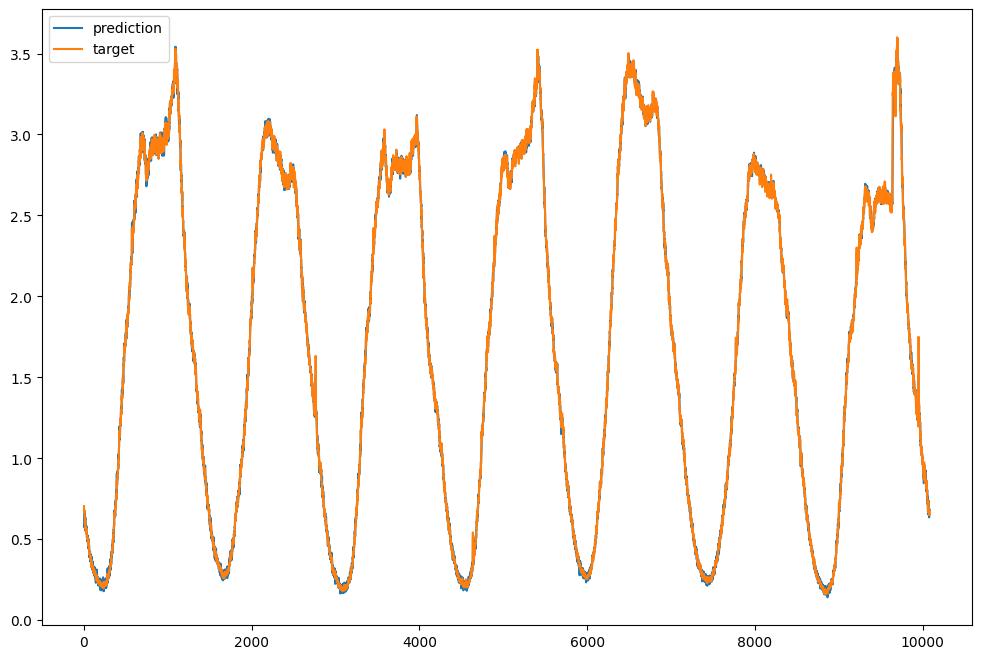

In [31]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [32]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 1.9551368951797485 %


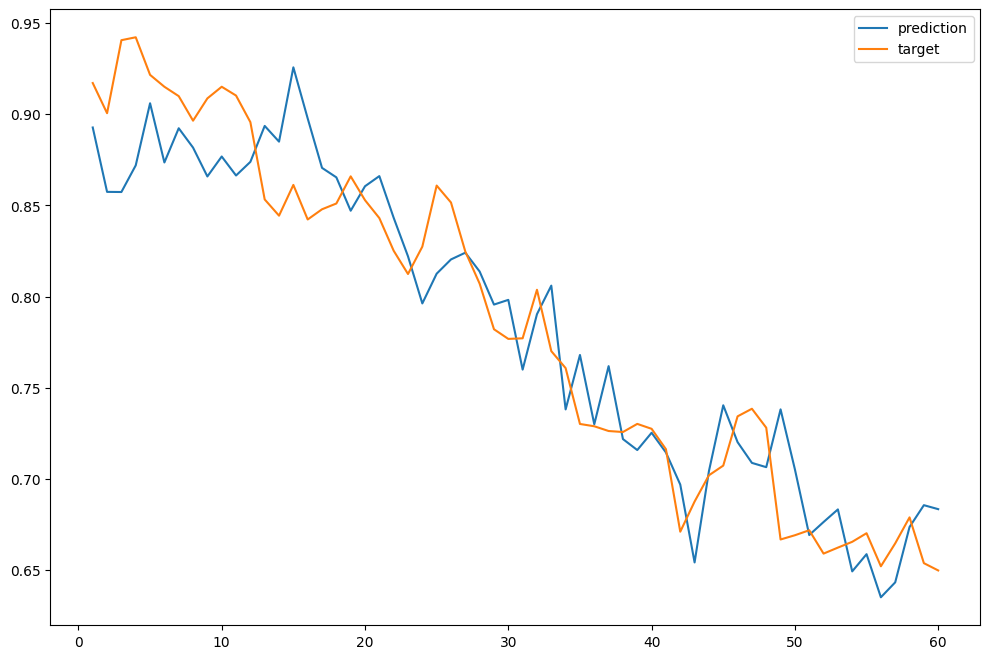

In [33]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [34]:
np.mean(time_list)

0.465208715862698